<a href="https://colab.research.google.com/github/mallikourtis/george4/blob/main/Teliki%20Askisis%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Πρώτες γραμμές του dataset:
          Src_IP  Src_Port          Dst_IP  Dst_Port  Protocol  Flow_Duration  \
0  10.152.152.11     57158   216.58.220.99       443         6            229   
1  10.152.152.11     57159   216.58.220.99       443         6            407   
2  10.152.152.11     57160   216.58.220.99       443         6            431   
3  10.152.152.11     49134  74.125.136.120       443         6            359   
4  10.152.152.11     34697  173.194.65.127     19305         6       10778451   

   Total_Fwd_Packet  Total_Bwd_packets  Total_Length_of_Fwd_Packet  \
0                 1                  1                           0   
1                 1                  1                           0   
2                 1                  1                           0   
3                 1                  1                           0   
4               591                400                       64530   

   Total_Length_of_Bwd_Packet  ...  Active_Mean  Active_Std  Act

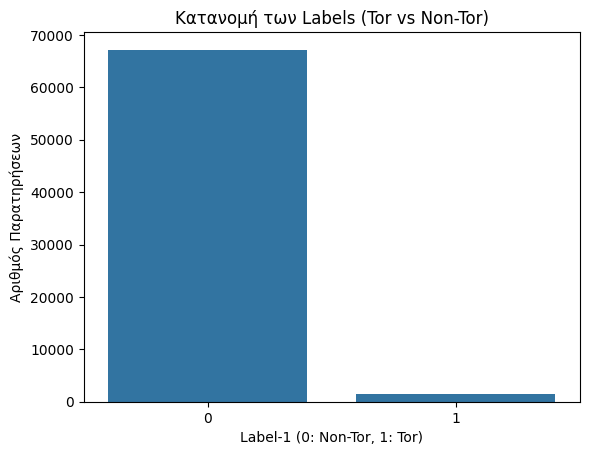

<ipython-input-35-1fda97dea8af>:46: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()


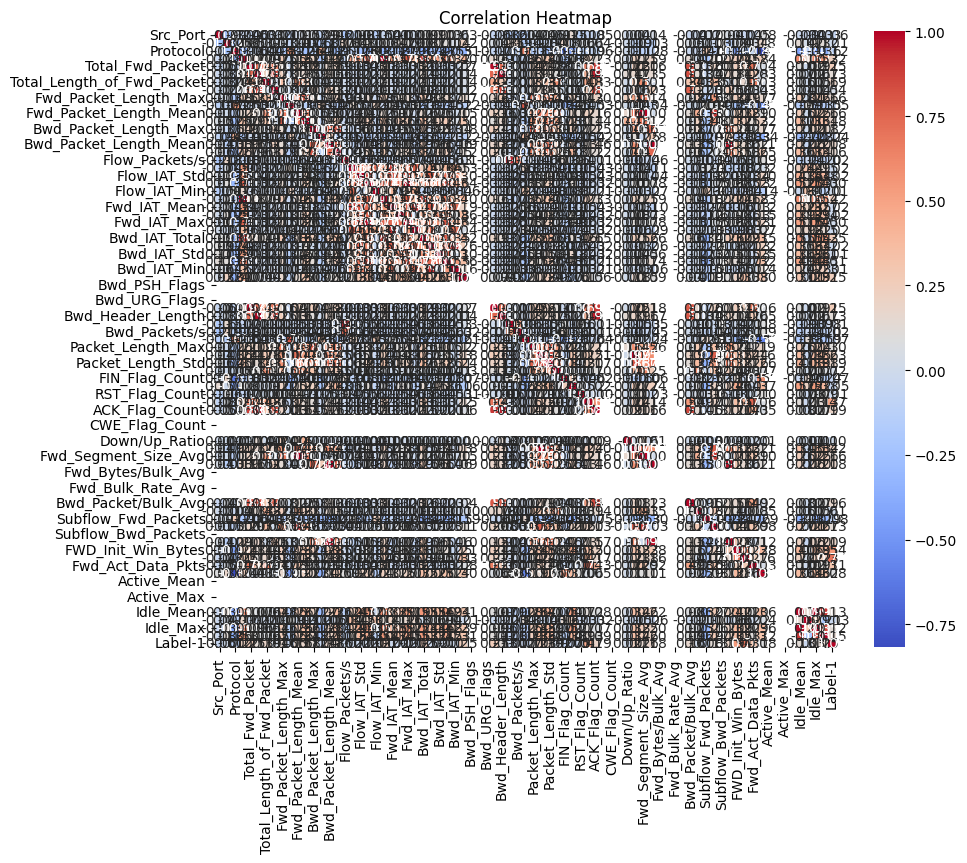

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65     20157
           1       0.65      0.71      0.68     20156

    accuracy                           0.67     40313
   macro avg       0.67      0.67      0.66     40313
weighted avg       0.67      0.67      0.66     40313

Random Forest Confusion Matrix:
 [[12569  7588]
 [ 5902 14254]]
Ξεκινά η βελτιστοποίηση με GridSearchCV για το XGBoost...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [35]:
# Εγκατάσταση απαραίτητων πακέτων
!pip install pyod
!pip install ppscore matplotlib seaborn pandas
!pip install --upgrade xgboost scikit-learn

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Καταστολή προειδοποιήσεων
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Load the dataset
file_path = "https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/DarkNet.csv"
dataset = pd.read_csv(file_path, low_memory=False)

# Καθαρισμός δεδομένων
dataset = dataset.drop(columns=[col for col in ['Unnamed: 1', 'Label-1.1', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6'] if col in dataset.columns])
dataset['Label-2'] = dataset['Label-2'].str.upper().str.replace('-', '_')
dataset['Label-1'] = dataset['Label-1'].apply(lambda x: 1 if x.upper() == 'TOR' else 0)

# Exploratory Data Analysis (EDA)
print("Πρώτες γραμμές του dataset:")
print(dataset.head())

print("\nΠεριγραφή των δεδομένων:")
print(dataset.describe())

print("\nΚατανομή των Labels:")
print(dataset['Label-1'].value_counts())

# Οπτικοποίηση κατανομής Labels
sns.countplot(data=dataset, x='Label-1')
plt.title('Κατανομή των Labels (Tor vs Non-Tor)')
plt.xlabel('Label-1 (0: Non-Tor, 1: Tor)')
plt.ylabel('Αριθμός Παρατηρήσεων')
plt.show()

# Heatmap συσχετίσεων
corr = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Oversampling της κατηγορίας Tor
tor_samples = dataset[dataset['Label-1'] == 1]
non_tor_samples = dataset[dataset['Label-1'] == 0]
oversampled_tor = tor_samples.sample(n=len(non_tor_samples), replace=True, random_state=42)
balanced_dataset = pd.concat([non_tor_samples, oversampled_tor]).sample(frac=1, random_state=42).reset_index(drop=True)

# Προετοιμασία χαρακτηριστικών και labels
X = balanced_dataset['Label-2'].str.get_dummies()
y = balanced_dataset['Label-1']

# Διαχωρισμός δεδομένων σε training και testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Αξιολόγηση Random Forest
rf_predictions = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classification Report:\n", rf_report)
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)

# Σενάριο:
# Το σύστημα που υλοποιήσαμε έχει στόχο να ταξινομεί την κυκλοφορία σε Tor και Non-Tor.
# Η ταξινόμηση αυτή είναι κρίσιμη για έναν οργανισμό, καθώς βοηθάει στον εντοπισμό κακόβουλης δραστηριότητας που μπορεί να προέρχεται από το Darknet.
# Ο οργανισμός υποθέτει ότι οποιαδήποτε κυκλοφορία από το Tor πρέπει να ελεγχθεί, καθώς μπορεί να αποτελεί μέσο επιθέσεων ή διαρροής δεδομένων.
# Το μοντέλο μας βασίζεται σε δύο μεθόδους:
# - Random Forest για γρήγορη και αξιόπιστη ταξινόμηση.
# - XGBoost, που είναι γνωστό για την ακρίβεια και την απόδοσή του σε πολύπλοκα δεδομένα.

# GridSearchCV για XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Εκπαίδευση GridSearchCV
print("Ξεκινά η βελτιστοποίηση με GridSearchCV για το XGBoost...")
grid_search_xgb.fit(X_train, y_train)

# Καλύτερες παράμετροι και σκορ
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_
print("Best Parameters for XGBoost:", best_params_xgb)
print("Best Score for XGBoost:", best_score_xgb)

# Εκπαίδευση XGBoost με τις βέλτιστες παραμέτρους
xgb_best_model = XGBClassifier(**best_params_xgb, eval_metric='logloss', random_state=42)
xgb_best_model.fit(X_train, y_train)

# Αξιολόγηση του XGBoost
print("Αξιολόγηση του βέλτιστου μοντέλου XGBoost...")
y_pred_best_xgb = xgb_best_model.predict(X_test)
xgb_best_report = classification_report(y_test, y_pred_best_xgb)
xgb_best_conf_matrix = confusion_matrix(y_test, y_pred_best_xgb)

print("Best XGBoost Classification Report:\n", xgb_best_report)
print("Best XGBoost Confusion Matrix:\n", xgb_best_conf_matrix)

<ipython-input-25-4306e067de65>:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


RandomForestClassifier(random_state=42)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65     20157
           1       0.65      0.71      0.68     20156

    accuracy                           0.67     40313
   macro avg       0.67      0.67      0.66     40313
weighted avg       0.67      0.67      0.66     40313

Random Forest Confusion Matrix:
 [[12569  7588]
 [ 5902 14254]]


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65     20157
           1       0.65      0.71      0.68     20156

    accuracy                           0.67     40313
   macro avg       0.67      0.67      0.66     40313
weighted avg       0.67      0.67      0.66     40313

XGBoost Confusion Matrix:
 [[12569  7588]
 [ 5902 14254]]
